<a href="https://colab.research.google.com/github/FrozenPeak0701/MusicCopilotGPT/blob/main/TransformerTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L
!lscpu |grep 'Model name'

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-09430fcb-6b53-ead8-15c1-b3cc2a703a57)
Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz


In [2]:
!pip install tokenizers
!pip install datasets


from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

class Transformer(nn.Module):
    def __init__(self, embedding_size, num_heads, hidden_dim, num_layers, output_dim, dropout, device, max_length=700):
        super().__init__()

        self.device = device

        self.embedding = nn.Embedding(embedding_size, embedding_size)
        self.pos_embedding = nn.Embedding(max_length, embedding_size)
        self.transformer = nn.Transformer(embedding_size, num_heads, num_layers, num_layers, hidden_dim, dropout)
        self.fc = nn.Linear(embedding_size, output_dim)
        self.dropout = nn.Dropout(dropout)

    def make_pos_tensor(self, text):
        # make sure to transpose the text tensor to get [seq_len, batch_size] shape
        return torch.arange(0, text.size(0)).unsqueeze(0).repeat(text.size(1), 1).T.to(self.device)

    def forward(self, text):
        text = text.T  # make sure the input tensor has shape [seq_len, batch_size]
        embedded = self.dropout(self.embedding(text) + self.pos_embedding(self.make_pos_tensor(text)))
        transformer_output = self.transformer(embedded, embedded)  # pass 'embedded' as both src and tgt
        pooled = transformer_output.mean(dim=0)  # change dimension to 0
        return self.fc(pooled)


# Setup a new tokenizer
tokenizer = Tokenizer(BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = Whitespace()

# Prepare the dataset
dataset = load_dataset("ag_news")
train_dataset = dataset['train']
test_dataset = dataset['test']

# Prepare the text for training the tokenizer
with open('ag_news.txt', 'w') as f:
    for example in train_dataset:
        f.write(example['text'] + '\n')

# Train the tokenizer on the AG News dataset
trainer = BpeTrainer(special_tokens=["<unk>", "<cls>", "<sep>", "<pad>", "<mask>"], vocab_size=800)
tokenizer.train(files=["./ag_news.txt"], trainer=trainer)

# Define pipeline for text and labels
text_pipeline = lambda x: tokenizer.encode(x).ids
label_pipeline = lambda x: int(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for example in batch:
        _label = example['label']
        _text = example['text']
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
trainer.vocab_size

800

In [4]:
# Define the model, optimizer, and loss function
model = Transformer(trainer.vocab_size, 8, 256, 2, 4, 0.5, device).to(device)
learning_rate = 1e-5
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 18,244,228 trainable parameters


In [6]:
len(train_dataloader), len(test_dataloader)

(7500, 475)

In [7]:
model

Transformer(
  (embedding): Embedding(800, 800)
  (pos_embedding): Embedding(700, 800)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=800, out_features=800, bias=True)
          )
          (linear1): Linear(in_features=800, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=800, bias=True)
          (norm1): LayerNorm((800,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((800,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
      )
      (norm): LayerNorm((800,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 

In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Train the model
N_EPOCHS = 20
train_losses = []
val_losses = []
for epoch in range(N_EPOCHS):
    epoch_loss = 0
    model.train()
    for i, (labels, text, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predictions = model(text)
        # print(predictions.shape, labels.shape)
        # print(predictions)
        # print(labels)
        loss = criterion(predictions, labels.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        if (i%1000 == 0):
          print(predictions.argmax(1))
          print(labels)
          print(f'| Step: {i}, Loss: {loss.detach().item()}')
    train_losses.append(epoch_loss/len(train_dataloader))
    print(f'Epoch: {epoch+1}, Train Loss: {epoch_loss/len(train_dataloader)}')
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (labels, text, _) in enumerate(test_dataloader):
            predictions = model(text)
            loss = criterion(predictions, labels.long())
            val_loss += loss.detach().item()
        val_losses.append(val_loss/len(test_dataloader))
        print(f'Validation Loss: {val_loss/len(test_dataloader)}')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
| Step: 0, Loss: 1.4812411069869995
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
| Step: 1000, Loss: 1.1256924867630005
tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 3, 0, 0, 1, 1, 0], device='cuda:0')
| Step: 2000, Loss: 0.7358421683311462
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([3, 1, 0, 0, 0, 0, 2, 3, 1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
| Step: 3000, Loss: 1.188382863998413
tensor([3, 1, 3, 2, 2, 0, 3, 0, 2, 0, 0, 2, 1, 1, 2, 3], device='cuda:0')
tensor([3, 1, 3, 1, 1, 0, 3, 3, 3, 0, 0, 1, 1, 3, 1, 1], device='cuda:0')
| Step: 4000, Loss: 1.3341556787490845
tensor([0, 3, 1, 2, 3, 1, 2, 0, 3, 1, 1, 1, 1, 1, 3, 2], device='cuda

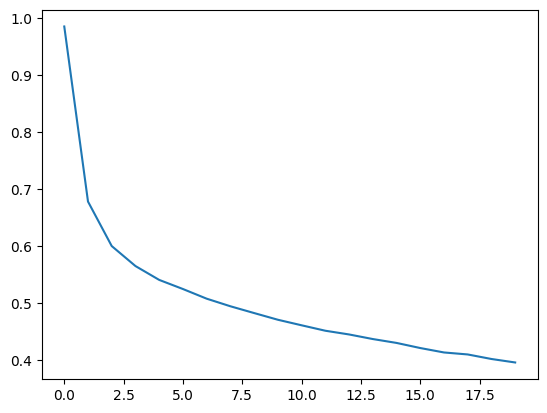

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

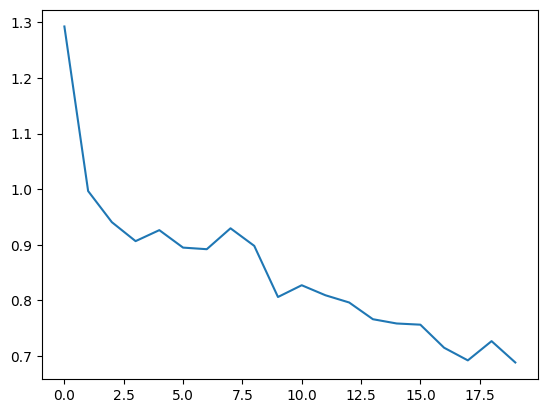

In [10]:
plt.plot(val_losses)

In [11]:
def get_specific_batch(dataloader, batch_idx):
    for i, batch in enumerate(dataloader):
        if i == batch_idx:
            return batch
    return None

specific_batch = get_specific_batch(train_dataloader, 1176)
specific_batch

(tensor([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 tensor([[328,  68,  46,  ...,   0,   0,   0],
         [ 37, 110,  96,  ...,   0,   0,   0],
         [ 46,  73, 160,  ...,   0,   0,   0],
         ...,
         [540,  33, 245,  ..., 248, 168, 381],
         [170, 614, 126,  ...,   0,   0,   0],
         [ 36,  50,  47,  ...,   0,   0,   0]], device='cuda:0'),
 tensor([   0,   81,  182,  340,  465,  526,  614,  680,  748,  820,  951, 1000,
         1158, 1237, 1411, 1551], device='cuda:0'))